# Mathematical Trading Strategies - Assignment 2

[What is EMA? How to Use Exponential Moving Average With Formula](https://www.investopedia.com/terms/e/ema.asp)
[How To Use a Moving Average to Buy Stocks](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp)
[Exponential Moving Average Trading Strategy](https://www.netpicks.com/three-moving-average-crossover/)

The objective of this assignment is to analyze the NASDAQ and NSE indices to identify their correlation and establish potential lead-lag relationships. The next step is to code Keltner Channel, Bollinger Bands, and MACD indicators, determining the optimal parameters for these indicators on one of the indices, and generating buy and sell signals on the other index.
Note : Utilize the established relationship to determine which index should be used for parameter optimization and which one for trading purposes.

Tasks:

Correlation Analysis:
a) Collect historical data for NASDAQ and NSE indices.
b) Calculate the correlation coefficient between the two indices.
c) Analyze the strength and direction of the relationship.

Lead-Lag Relationship:
a) Identify potential lead-lag relationships between the indices.
b) Analyze data to determine consistent leading or lagging behavior.
c) Use the lead-lag relationship to determine the index to be used for parameter optimization.
d) Provide an explanation for choosing the index for parameter optimization

Indicator Coding:
a) Code Keltner Channel, Bollinger Bands, and MACD indicators.

Parameter Optimization:
a) Optimize parameters for the indicators on one index.
b) Use metrics coded in last assignment to evaluate your strategy.
c) Document the optimized parameters for future reference.

Signal Generation:
a) Apply optimized parameters to the other index.
b) Generate buy and sell signals using the indicators.
c) Record the signals, their respective dates and returns along with other metrics covered before.

In [94]:
import yfinance as yf

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import t
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

## Task - 1 : Correlation Analysis

In [95]:
# df = pd.read_csv("./tmp/assignment2.csv")

In [96]:
nasdaq_df = yf.download("^IXIC", start="2010-01-01",end= "2023-05-01")
nasdaq_close = nasdaq_df["Adj Close"]
nse_df = yf.download("^NSEI", start="2010-01-01",end= "2023-05-01")
nse_close = nse_df["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [97]:
nse_close.shape, nasdaq_close.shape

((3268,), (3353,))

In [98]:
# concatenate the two series to use the pandas df.corr() method to calculate corr coeff
df = pd.DataFrame({"NASDAQ": nasdaq_close,
                   "NSE": nse_close,
            },
                  index = nasdaq_close.index
        )
df.dropna(inplace=True) # To take only common trading days

In [99]:
round(df.corr().iloc[0,1],3)

0.951

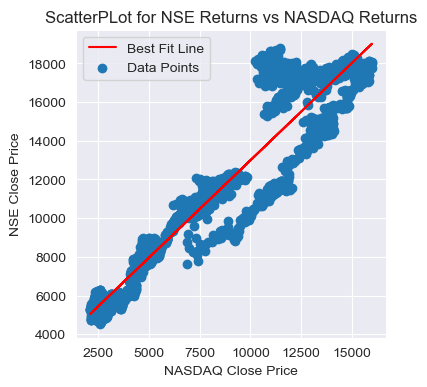

In [100]:
plt.figure(figsize=(4, 4))
# Fitting a linear regression model
regression = LinearRegression()
regression.fit(df.NASDAQ.values.reshape(-1, 1), df.NSE.values.reshape(-1, 1))

# Predicting the best fit line
predicted_nsei_close = regression.predict(df.NASDAQ.values.reshape(-1, 1))

# Plotting the best fit line
plt.plot(df.NASDAQ, predicted_nsei_close, color='red', label='Best Fit Line')

plt.scatter(df.NASDAQ,df.NSE, label='Data Points')
plt.xlabel("NASDAQ Close Price")
plt.ylabel("NSE Close Price")
plt.title("ScatterPLot for NSE Returns vs NASDAQ Returns")
plt.legend()
plt.show()

Both the indices have a have a weak **Positive Correlation**

## Task - 2 : Lead - Lag Relationship

### Granger Causality Test

In [101]:
from statsmodels.tsa.stattools import grangercausalitytests

In [102]:
results = grangercausalitytests(df, maxlag=10, verbose=False)

In [103]:
for lag in results.keys():
    p_value = results[lag][0]['ssr_chi2test'][1]
    if p_value < 0.05:
        print(f"Lag {lag}: NSE leads NASDAQ (p-value: {p_value})")
    else:
        print(f"Lag {lag}: NASDAQ leads NSE (p-value: {p_value})")

Lag 1: NASDAQ leads NSE (p-value: 0.3964519669207568)
Lag 2: NSE leads NASDAQ (p-value: 0.0021427470472387836)
Lag 3: NSE leads NASDAQ (p-value: 0.0006444399374752586)
Lag 4: NSE leads NASDAQ (p-value: 0.0012407803846418975)
Lag 5: NSE leads NASDAQ (p-value: 7.472544829055893e-05)
Lag 6: NSE leads NASDAQ (p-value: 1.4905532783271078e-05)
Lag 7: NSE leads NASDAQ (p-value: 2.971480497896662e-05)
Lag 8: NSE leads NASDAQ (p-value: 3.510997450740077e-06)
Lag 9: NSE leads NASDAQ (p-value: 2.947618970202636e-06)
Lag 10: NSE leads NASDAQ (p-value: 1.9560630812885236e-06)


using Granger Causality test we infer that NSE leads NASDAQ

Plotting the data of NASDAQ and NSE

## Task - 3 : Indicator Coding

In [104]:
def calculate_keltner_channel(dataframe, period=20, multiplier=2):
    high = dataframe['High']
    low = dataframe['Low']
    close = dataframe['Close']

    tr = pd.DataFrame(index=dataframe.index)
    tr['h-l'] = high - low
    tr['h-pc'] = abs(high - close.shift(1))
    tr['l-pc'] = abs(low - close.shift(1))

    true_range = tr.max(axis=1)
    atr = true_range.rolling(window=period).mean()

    upper_band = close.rolling(window=period).mean() + (multiplier * atr)
    middle_band = close.rolling(window=period).mean()
    lower_band = close.rolling(window=period).mean() - (multiplier * atr)

    return upper_band, lower_band, middle_band

In [105]:
date_from = "2020-01-01"
date_to = "2022-01-01"
nasdaq_df_recent = nasdaq_df[datetime.strptime(date_from, "%Y-%m-%d").date():datetime.strptime(date_to, "%Y-%m-%d").date()]

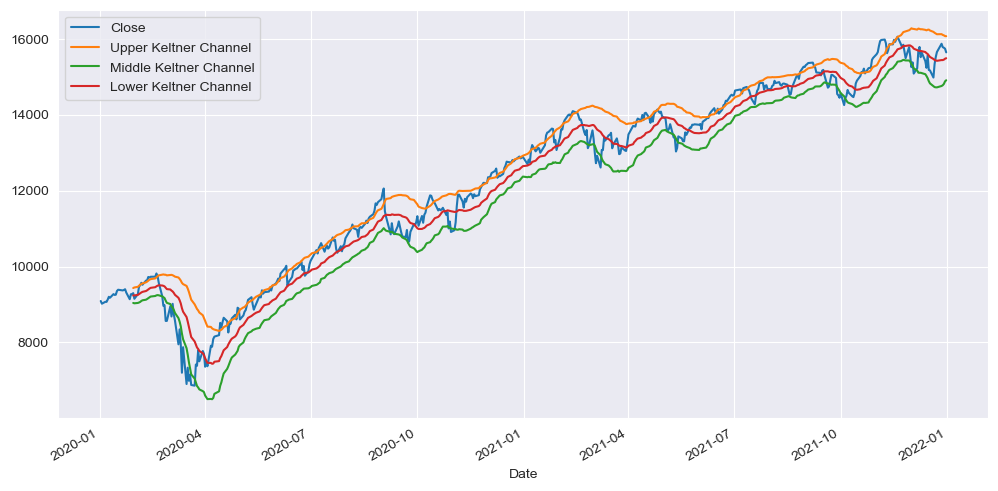

In [106]:
plt.figure(figsize=(12, 6))
upper_keltner, middle_keltner, lower_keltner = calculate_keltner_channel(nasdaq_df_recent)
nasdaq_df_recent['Close'].plot(label='Close')
upper_keltner.plot(label='Upper Keltner Channel')
middle_keltner.plot(label='Middle Keltner Channel')
lower_keltner.plot(label='Lower Keltner Channel')
plt.legend()
plt.show()

In [107]:
def calculate_bollinger_bands(dataframe, period=20, multiplier=2):
    sma = dataframe['Close'].rolling(window=period).mean()
    rolling_std = dataframe['Close'].rolling(window=period).std()
    upper_band = sma + (multiplier * rolling_std)
    lower_band = sma - (multiplier * rolling_std)
    return upper_band, sma, lower_band

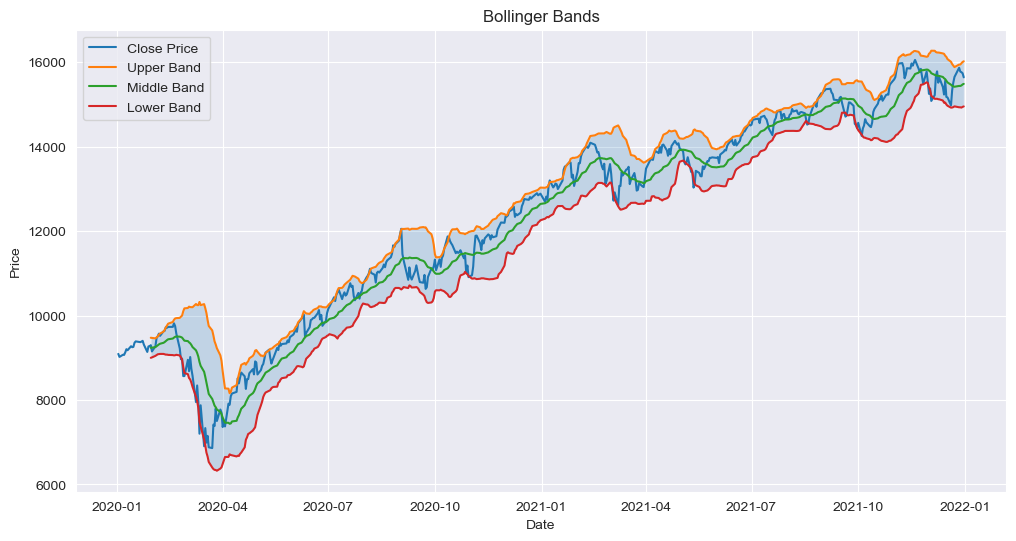

In [108]:
# Calculate Bollinger Bands
upper_bollinger, middle_bollinger, lower_bollinger = calculate_bollinger_bands(nasdaq_df_recent)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df_recent['Close'], label='Close Price')
# plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(upper_bollinger, label='Upper Band')
plt.plot(middle_bollinger, label='Middle Band')
plt.plot(lower_bollinger, label='Lower Band')
plt.fill_between(nasdaq_df_recent.index, lower_bollinger, upper_bollinger, alpha=0.2)  # Fill between the bands
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [109]:
def calculate_macd(dataframe, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = dataframe['Close'].ewm(span=fastperiod).mean()
    ema_slow = dataframe['Close'].ewm(span=slowperiod).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signalperiod).mean()
    histogram = macd - signal

    return macd, signal, histogram

In [110]:
date_from = "2023-01-01"
nasdaq_df_recent = nasdaq_df[datetime.strptime(date_from, "%Y-%m-%d").date():datetime.today().date()]

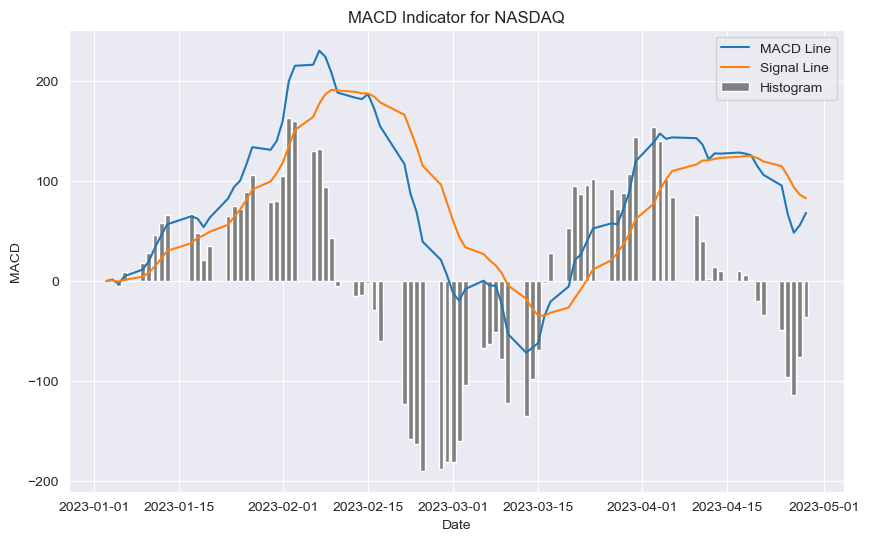

In [111]:
macd_line, signal_line, macd_histogram = calculate_macd(nasdaq_df_recent)

plt.figure(figsize=(10, 6))
plt.plot(nasdaq_df_recent.index, macd_line, label='MACD Line')
plt.plot(nasdaq_df_recent.index, signal_line, label='Signal Line')
plt.bar(nasdaq_df_recent.index, macd_histogram*2.5, label='Histogram', color='gray')
plt.legend()
plt.title('MACD Indicator for NASDAQ')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.show()

## Task - 4 : Parameter Optimisation

In [112]:
# Define parameter ranges for optimization
keltner_channel_periods = range(10, 51, 5)
keltner_channel_atr_periods = range(10, 31, 5)
bollinger_bands_periods = range(10, 51, 5)
macd_short_periods = range(10, 31, 5)
macd_long_periods = range(30, 51, 5)
macd_signal_periods = range(5, 21, 5)

In [113]:
best_params = {}
best_metrics = {
    'returns': -np.inf,
    'cumulative_returns': -np.inf,
    'max_drawdown': np.inf,
    'sharpe_ratio': -np.inf,
    'sortino_ratio': -np.inf
}

In [114]:
# Loop through parameter combinations and evaluate metrics
for kcp in keltner_channel_periods:
    for bbp in bollinger_bands_periods:
        for msp in macd_short_periods:
            for mlp in macd_long_periods:
                for mspc in macd_signal_periods:
                    # Calculate indicators
                    kc_upper, kc_middle, kc_lower = calculate_keltner_channel(nasdaq_df,period=kcp)

                    bb_upper, bb_middle, bb_lower = calculate_bollinger_bands(nasdaq_df, period=bbp)

                    macd, macd_signal, _ = calculate_macd(nasdaq_df, fastperiod=msp, slowperiod=mlp, signalperiod=mspc)

                    # Generate trading signals based on indicators
                    signals = np.zeros(len(nasdaq_close))
                    signals[(nasdaq_close > kc_upper) & (nasdaq_close.shift(1) <= kc_upper.shift(1))] = 1
                    signals[(nasdaq_close < kc_lower) & (nasdaq_close.shift(1) >= kc_lower.shift(1))] = -1

                    # Apply signals to calculate strategy returns
                    strategy_returns = signals * nasdaq_close.pct_change().shift(-1)
                    cumulative_returns = (1 + strategy_returns).cumprod()
                    max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()
                    sharpe_ratio = np.mean(strategy_returns) / np.std(nasdaq_close.pct_change())
                    negative_returns = strategy_returns[strategy_returns < 0]
                    sortino_ratio = np.mean(strategy_returns) / np.std(negative_returns)

                    # Update best metrics and parameters if improved
                    if strategy_returns.iloc[-2] > best_metrics['returns']:
                        best_metrics['returns'] = strategy_returns.iloc[-2]
                        best_metrics['cumulative_returns'] = cumulative_returns.iloc[-2]
                        best_metrics['max_drawdown'] = max_drawdown
                        best_metrics['sharpe_ratio'] = sharpe_ratio
                        best_metrics['sortino_ratio'] = sortino_ratio
                        best_params['keltner_channel'] = kcp
                        best_params['bollinger_bands'] = bbp
                        best_params['macd'] = (msp, mlp, mspc)

In [115]:
# Print the optimized parameters and metrics
print("Optimized Parameters:")
print("Keltner Channel Period:", best_params['keltner_channel'])
print("Bollinger Bands Period:", best_params['bollinger_bands'])
print("MACD Parameters:", best_params['macd'])

Optimized Parameters:
Keltner Channel Period: 10
Bollinger Bands Period: 10
MACD Parameters: (10, 30, 5)


In [116]:
print("\nOptimized Metrics:")
print("Returns:", best_metrics['returns'])
print("Cumulative Returns:", best_metrics['cumulative_returns'])
print("Max Drawdown:", best_metrics['max_drawdown'])
print("Sharpe Ratio:", best_metrics['sharpe_ratio'])
print("Sortino Ratio:", best_metrics['sortino_ratio'])


Optimized Metrics:
Returns: 0.0
Cumulative Returns: 0.8142624384045334
Max Drawdown: -0.4043631212572034
Sharpe Ratio: -0.004017230299828337
Sortino Ratio: -0.005347006668376557


## Task 5 - Signal Generation

In [117]:
# Set the optimum parameters as the parameters
kcp = best_params['keltner_channel']
bbp = best_params['bollinger_bands']
msp,mlp,mspc = best_params['macd']

### Keltner Channel

In [118]:
kc_nse = calculate_keltner_channel(nse_df, kcp)
kc_nasdaq = calculate_keltner_channel(nasdaq_df, kcp)

In [119]:
nse_cumulative_returns_kc = nse_close.pct_change().cumsum() + 1
nse_max_drawdown_kc = ((nse_cumulative_returns_kc.cummax() - nse_cumulative_returns_kc) / nse_cumulative_returns_kc.cummax()).max()
nse_sharpe_ratio_kc = np.mean(nse_close.pct_change()) / np.std(nse_close.pct_change())

In [120]:
# Print the metrics for NSE using each indicator separately
print("Metrics for NSE using Keltner Channel:")
print("Cumulative Returns:", (nse_cumulative_returns_kc.iloc[-1] - 1) * 100)
print("Max Drawdown:", nse_max_drawdown_kc * 100)
print("Sharpe Ratio:", nse_sharpe_ratio_kc)

Metrics for NSE using Keltner Channel:
Cumulative Returns: 143.33738461672053
Max Drawdown: 25.386517694766013
Sharpe Ratio: 0.04036840238939697


In [121]:
nasdaq_cumulative_returns_kc = nasdaq_close.pct_change().cumsum() + 1
nasdaq_max_drawdown_kc = ((nasdaq_cumulative_returns_kc.cummax() - nasdaq_cumulative_returns_kc) / nasdaq_cumulative_returns_kc.cummax()).max()
nasdaq_sharpe_ratio_kc = np.mean(nasdaq_close.pct_change()) / np.std(nasdaq_close.pct_change())

In [122]:
# Print the metrics for NASDAQ using each indicator separately
print("\nMetrics for NASDAQ using Keltner Channel:")
print("Cumulative Returns:", (nasdaq_cumulative_returns_kc.iloc[-1] - 1) * 100)
print("Max Drawdown:", nasdaq_max_drawdown_kc * 100)
print("Sharpe Ratio:", nasdaq_sharpe_ratio_kc)


Metrics for NASDAQ using Keltner Channel:
Cumulative Returns: 195.08649749769535
Max Drawdown: 16.56845765541977
Sharpe Ratio: 0.044844032937014666


### Bollinger Bands

In [123]:
bb_nse = calculate_bollinger_bands(nse_df, bbp)
bb_nasdaq = calculate_bollinger_bands(nasdaq_df, bbp)

In [124]:
nse_cumulative_returns_bb = nse_close.pct_change().cumsum() + 1
nse_max_drawdown_bb = ((nse_cumulative_returns_bb.cummax() - nse_cumulative_returns_bb) / nse_cumulative_returns_bb.cummax()).max()
nse_sharpe_ratio_bb = np.mean(nse_close.pct_change()) / np.std(nse_close.pct_change())

In [125]:
# Print the metrics for NSE using each indicator separately
print("Metrics for NSE using Bollinger Bands:")
print("Cumulative Returns:", (nse_cumulative_returns_bb.iloc[-1] - 1) * 100)
print("Max Drawdown:", nse_max_drawdown_bb * 100)
print("Sharpe Ratio:", nse_sharpe_ratio_bb)

Metrics for NSE using Bollinger Bands:
Cumulative Returns: 143.33738461672053
Max Drawdown: 25.386517694766013
Sharpe Ratio: 0.04036840238939697


In [126]:
nasdaq_cumulative_returns_bb = nasdaq_close.pct_change().cumsum() + 1
nasdaq_max_drawdown_bb = ((nasdaq_cumulative_returns_bb.cummax() - nasdaq_cumulative_returns_bb) / nasdaq_cumulative_returns_bb.cummax()).max()
nasdaq_sharpe_ratio_bb = np.mean(nasdaq_close.pct_change()) / np.std(nasdaq_close.pct_change())

In [127]:
# Print the metrics for NASDAQ using each indicator separately
print("\nMetrics for NASDAQ using Bollinger Bands:")
print("Cumulative Returns:", (nasdaq_cumulative_returns_bb.iloc[-1] - 1) * 100)
print("Max Drawdown:", nasdaq_max_drawdown_bb * 100)
print("Sharpe Ratio:", nasdaq_sharpe_ratio_bb)


Metrics for NASDAQ using Bollinger Bands:
Cumulative Returns: 195.08649749769535
Max Drawdown: 16.56845765541977
Sharpe Ratio: 0.044844032937014666


### MACD

In [128]:
macd_nse = calculate_macd(nse_df, msp, mlp, mspc)
macd_nasdaq = calculate_macd(nasdaq_df, msp, mlp, mspc)

In [129]:
nse_cumulative_returns_macd = nse_close.pct_change().cumsum() + 1
nse_max_drawdown_macd = ((nse_cumulative_returns_macd.cummax() - nse_cumulative_returns_macd) / nse_cumulative_returns_macd.cummax()).max()
nse_sharpe_ratio_macd = np.mean(nse_close.pct_change()) / np.std(nse_close.pct_change())

In [130]:
# Print the metrics for NSE using each indicator separately
print("Metrics for NSE using Moving Average Convergence/Divergence:")
print("Cumulative Returns:", (nse_cumulative_returns_macd.iloc[-1] - 1) * 100)
print("Max Drawdown:", nse_max_drawdown_macd * 100)
print("Sharpe Ratio:", nse_sharpe_ratio_macd)

Metrics for NSE using Moving Average Convergence/Divergence:
Cumulative Returns: 143.33738461672053
Max Drawdown: 25.386517694766013
Sharpe Ratio: 0.04036840238939697


In [131]:
nasdaq_cumulative_returns_macd = nasdaq_close.pct_change().cumsum() + 1
nasdaq_max_drawdown_macd = ((nasdaq_cumulative_returns_macd.cummax() - nasdaq_cumulative_returns_macd) / nasdaq_cumulative_returns_macd.cummax()).max()
nasdaq_sharpe_ratio_macd = np.mean(nasdaq_close.pct_change()) / np.std(nasdaq_close.pct_change())

In [132]:
# Print the metrics for NASDAQ using each indicator separately
print("\nMetrics for NASDAQ using Moving Average Convergence/Divergence:")
print("Cumulative Returns:", (nasdaq_cumulative_returns_macd.iloc[-1] - 1) * 100)
print("Max Drawdown:", nasdaq_max_drawdown_macd * 100)
print("Sharpe Ratio:", nasdaq_sharpe_ratio_macd)


Metrics for NASDAQ using Moving Average Convergence/Divergence:
Cumulative Returns: 195.08649749769535
Max Drawdown: 16.56845765541977
Sharpe Ratio: 0.044844032937014666
